In [1]:
import torch
import numpy as np
import os
import sys
import math
import logging
import json
import datetime

from tqdm import tqdm, trange
from gctpyhealth.process_eicu_dataset import get_eicu_datasets
from gctpyhealth.utils import *
from gctpyhealth.gct import GCT

from tensorboardX import SummaryWriter
import torchsummary as summary


In [2]:
class Args:
    def __init__(self, prediction_task: str):
        if prediction_task == "expired":
            self.label_key = "expired"
            self.learning_rate = 0.00011
            self.reg_coef = 1.5
            self.hidden_dropout = 0.72
        elif prediction_task == "readmission":
            self.label_key = "readmission"
            self.learning_rate = 0.00022
            self.reg_coef = 0.1
            self.hidden_dropout = 0.08
        else:
            raise ValueError("Invalid prediction task: {}".format(prediction_task))

        # Training arguments
        self.max_steps = 5000  ### for short run # 1000000
        self.warmup = 0.05  # default
        self.logging_steps = 100  # default
        self.num_train_epochs = 1  # default
        self.seed = 42  # default

        # Model parameters arguments
        self.embedding_dim = 128
        self.max_num_codes = 50
        self.num_stacks = 3
        self.batch_size = 32
        self.prior_scalar = 0.5
        self.num_heads = 1

        # save and load the cache/dataset/env path (required)
        self.fold = 0
        self.data_dir = "eicu_data"
        self.eicu_csv_dir = "../eicu_csv"
        # timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # self.output_dir = "eicu_output/model_pyhealth_" + timestamp
        self.output_dir = "eicu_output/model_pyhealth_" + self.label_key

        # save and load the models (optional)
        self.save_model = False
        self.load_prev_model = True
        self.prev_model_path = "eicu_output/model_pyhealth_expired_embeddings/model.pt"


args = Args("expired")
set_seed(args.seed)

In [3]:
# Store the log data
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO
)

logger = logging.getLogger(__name__)

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
logging_dir = os.path.join(args.output_dir, 'logging')
if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)
tb_writer = SummaryWriter(log_dir=logging_dir)

In [4]:
# loading the eICU dataset
from pyhealth.datasets import eICUDataset

print('Loading eICU dataset')
eicu_ds = eICUDataset(
    root=args.eicu_csv_dir,
    tables=["admissionDx", "diagnosisString", "treatment"],
    refresh_cache=False,
    dev=True
)

print(eicu_ds.stat())
print(eicu_ds.info())

Loading eICU dataset

Statistics of base dataset (dev=True):
	- Dataset: eICUDataset
	- Number of patients: 3671
	- Number of visits: 5000
	- Number of visits per patient: 1.3620
	- Number of events per visit in admissionDx: 2.7186
	- Number of events per visit in diagnosisString: 4.8976
	- Number of events per visit in treatment: 0.0000


Statistics of base dataset (dev=True):
	- Dataset: eICUDataset
	- Number of patients: 3671
	- Number of visits: 5000
	- Number of visits per patient: 1.3620
	- Number of events per visit in admissionDx: 2.7186
	- Number of events per visit in diagnosisString: 4.8976
	- Number of events per visit in treatment: 0.0000


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info

None


In [5]:
# fetch the datatset from caches
datasets, prior_guides = get_eicu_datasets(args.data_dir, args.eicu_csv_dir, fold=args.fold)
train_dataset, eval_dataset, test_dataset = datasets
train_priors, eval_priors, test_priors = prior_guides
train_priors_dataset = eICUPriorDataset(train_priors)
eval_priors_dataset = eICUPriorDataset(eval_priors)
test_priors_dataset = eICUPriorDataset(test_priors)

# prepare data loader
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size)
eval_dataloader = DataLoader(eval_dataset, batch_size=args.batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size)

train_priors_dataloader = DataLoader(train_priors_dataset,
                                     batch_size=args.batch_size, collate_fn=priors_collate_fn)
eval_priors_dataloader = DataLoader(eval_priors_dataset,
                                    batch_size=args.batch_size, collate_fn=priors_collate_fn)
test_priors_dataloader = DataLoader(test_priors_dataset,
                                    batch_size=args.batch_size, collate_fn=priors_collate_fn)

Found cached data, loading...
loading cached data takes: 2.4638421535491943s


In [6]:
# check if gpu/cuda is available
n_gpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.set_device(device)
    logger.info('***** Using CUDA device *****')

05/03/2023 22:39:52 - INFO - __main__ - ***** Using CUDA device *****


In [7]:
# from pyhealth.models import Transformer
from gctpyhealth.gct import GCT

model = GCT(
    dataset=eicu_ds,
    feature_keys=['conditions_hash',
                  'procedures_hash'],
    label_key=args.label_key,
    mode="binary",
    embedding_dim=args.embedding_dim,
    max_num_codes=args.max_num_codes,
    num_stacks=args.num_stacks,
    batch_size=args.batch_size,
    reg_coef=args.reg_coef,
    prior_scalar=args.prior_scalar,
    hidden_dropout=args.hidden_dropout,
    num_heads=args.num_heads,
)

# loading previous checkpoint if available
checkpoint = None
if args.load_prev_model:
    checkpoint = torch.load(args.prev_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)


In [8]:
# Evaluation
eval_results = {}
model.eval()

logger.info('*** Evaluate ***')
logger.info(' Num examples = {}'.format(len(eval_dataloader.dataset)))
eval_result = prediction_loop(device, args.label_key, model, eval_dataloader, eval_priors_dataloader)
output_eval_file = os.path.join(args.output_dir, 'eval_results.txt')

with open(output_eval_file, 'a') as writer:
    logger.info('*** Eval results @ steps:{} ***\n'.format(0))
    writer.write('*** Eval results @ steps:{} ***\n'.format(0))
    for key, value in eval_result.items():
        logger.info('{} = {}\n'.format(key, value))
        writer.write('{} = {}\n'.format(key, value))
eval_results.update(eval_result)

05/03/2023 22:39:53 - INFO - __main__ - *** Evaluate ***
05/03/2023 22:39:53 - INFO - __main__ -  Num examples = 4103
Evaluating: 129it [00:01, 85.40it/s] 
05/03/2023 22:39:54 - INFO - __main__ - *** Eval results @ steps:0 ***

05/03/2023 22:39:54 - INFO - __main__ - eval_loss = 19.04744755509944

05/03/2023 22:39:54 - INFO - __main__ - eval_AUCPR = 0.560398372276906

05/03/2023 22:39:54 - INFO - __main__ - eval_AUROC = 0.7630389091540734



t-SNE plot

In [14]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [31]:
# Extract the weights from the embedding layer
dx_weights = model.embeddings.dx_embeddings.weight.data.cpu().numpy()
proc_weights = model.embeddings.proc_embeddings.weight.data.cpu().numpy()
visit_weights = model.embeddings.visit_embeddings.weight.data.cpu().numpy()


In [34]:

# Create a t-SNE object with 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
# Fit the t-SNE object to the weights
transformed_weights = tsne.fit_transform(dx_weights)

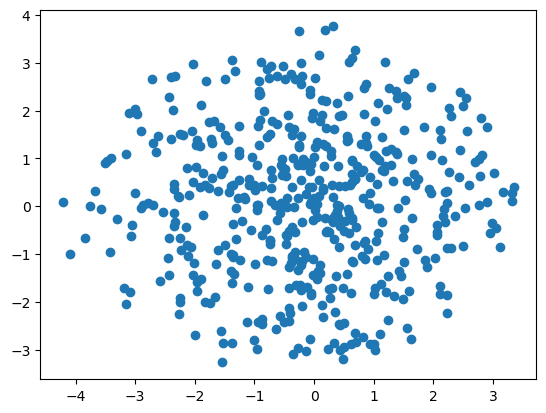

In [36]:
# # Plot the transformed weights
plt.scatter(transformed_weights[1000:1500,0], transformed_weights[1000:1500,1])
plt.show()

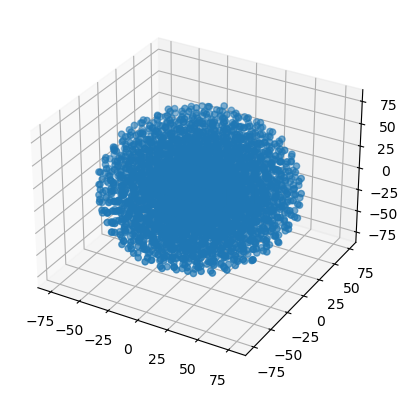

In [29]:
# Plot the transformed weights in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_weights[:,0], transformed_weights[:,1], transformed_weights[:,2])
plt.show()

In [ ]:
# plot the visit embeddings which is a 1x128 data
